In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import pmdarima as pm
import numpy as np
df = pd.read_parquet("~/downloads/steam_hw_survey.parquet")

df.shape


(262470, 5)

This dataset aggregates OS data from 2014 (The first year that steam started collecting data on Linux ) to December 2021. Market share by month is provided by the category "OS version (total)". The goal here is to get a sense of the data and then push it through three autoregression models, one for each platform. Then I plan to evaluate performance via RMSE.

In [7]:
df.isnull().sum()

index       0
perc        0
category    0
date        0
platform    0
dtype: int64

In [8]:
df.head()

,index,perc,category,date,platform
0,Unspecified,10.01,Network Speed,2004-04-01,pc
1,14.4 Kbps,0.10,Network Speed,2004-04-01,pc
2,28.8 Kbps,0.18,Network Speed,2004-04-01,pc
3,33.6 Kbps,0.13,Network Speed,2004-04-01,pc
4,56.0 Kbps,3.38,Network Speed,2004-04-01,pc


In [9]:
df_total_os = df[df['category'] == 'OS Version (total)'].copy()

df_os_share = df_total_os.pivot_table(
    index='date',
    columns='index',     # OS label: Windows, OSX, Linux
    values='perc',
    aggfunc='sum'
).fillna(method='ffill')

/var/folders/95/lqnz31wj1856lzxvq3fhfxmw0000gn/T/ipykernel_56286/3892371037.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ).fillna(method='ffill')


In [10]:
df_os_share.head()

index,Linux,OSX,Windows
date,,,
2014-02-01,0.86,3.47,94.93
2014-03-01,1.30,3.42,95.17
2014-04-01,1.20,3.54,95.12
2014-05-01,1.26,3.36,95.25
2014-06-01,1.10,3.30,95.50


/var/folders/95/lqnz31wj1856lzxvq3fhfxmw0000gn/T/ipykernel_56286/961353150.py:1: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  df_yearly = df_os_share.resample("Y").mean()


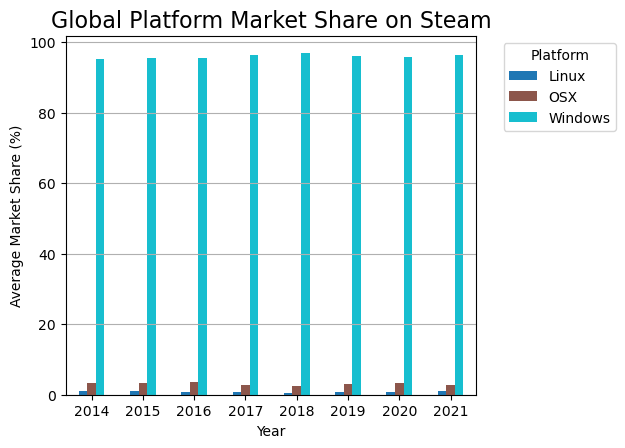

In [11]:


df_yearly = df_os_share.resample("Y").mean()

df_yearly.index = df_yearly.index.year 
ax = df_yearly.plot(
    kind="bar",
    stacked=False,
    colormap="tab10"
)



plt.title("Global Platform Market Share on Steam", fontsize=16)
plt.xlabel("Year")
plt.ylabel("Average Market Share (%)")
plt.legend(title="Platform", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, axis='y')
plt.tight_layout()
plt.xticks(rotation=0)
plt.show()

In [12]:
df_yearly

index,Linux,OSX,Windows
date,,,
2014,1.136364,3.408182,95.279091
2015,0.975000,3.321667,95.600833
2016,0.879167,3.496667,95.509167
2017,0.664167,2.802500,96.447500
2018,0.525000,2.471667,96.953333
2019,0.808333,3.090000,96.100000
2020,0.870000,3.400000,95.730000
2021,0.942500,2.785833,96.272500


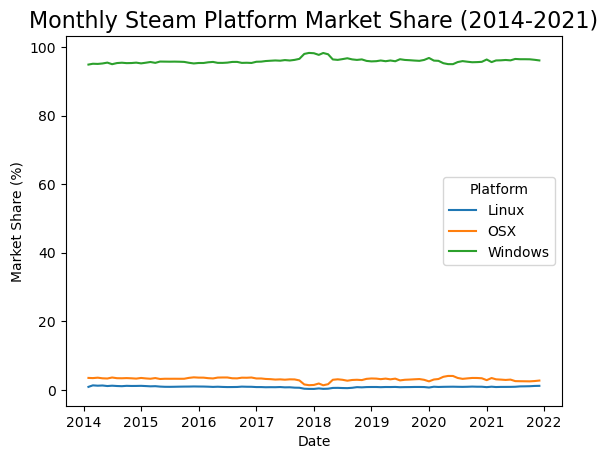

In [13]:


for platform in df_os_share.columns:
    plt.plot(df_os_share.index, df_os_share[platform], label=platform)

plt.title('Monthly Steam Platform Market Share (2014-2021)', fontsize=16)
plt.xlabel('Date')
plt.ylabel('Market Share (%)')
plt.legend(title='Platform')
plt.show()


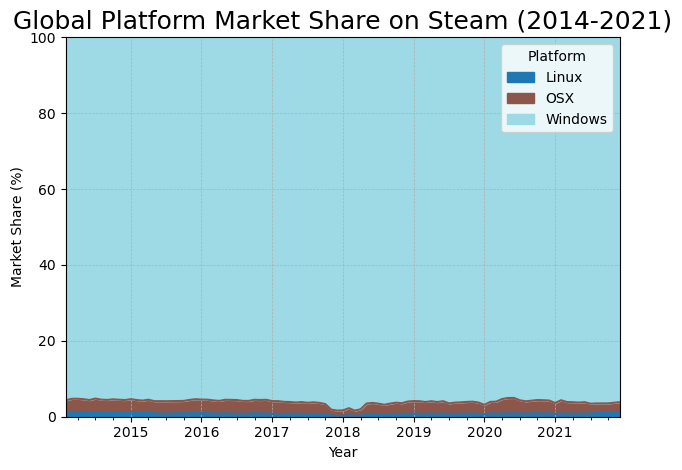

In [14]:
df_os_share.plot.area(
    colormap="tab20",
)

plt.title("Global Platform Market Share on Steam (2014-2021)", fontsize=18)
plt.xlabel("Year")
plt.ylabel("Market Share (%)")
plt.ylim(0, 100)
plt.legend(title="Platform")
plt.grid(True, linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()


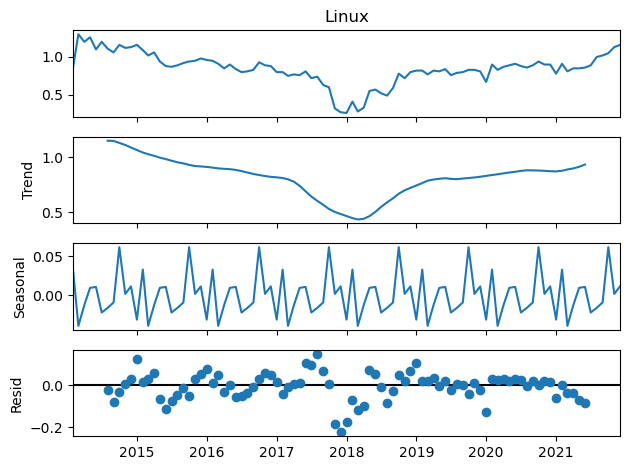

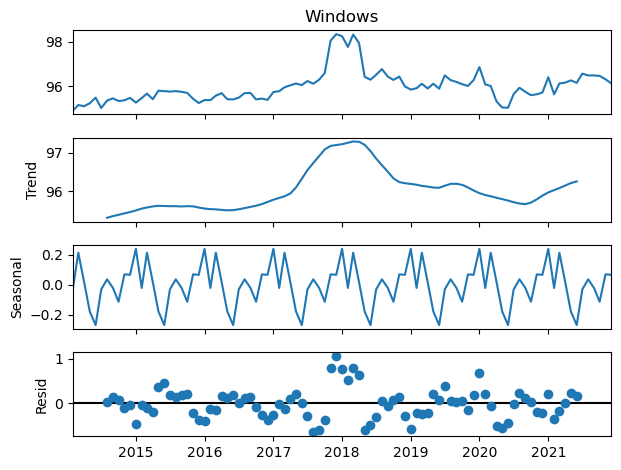

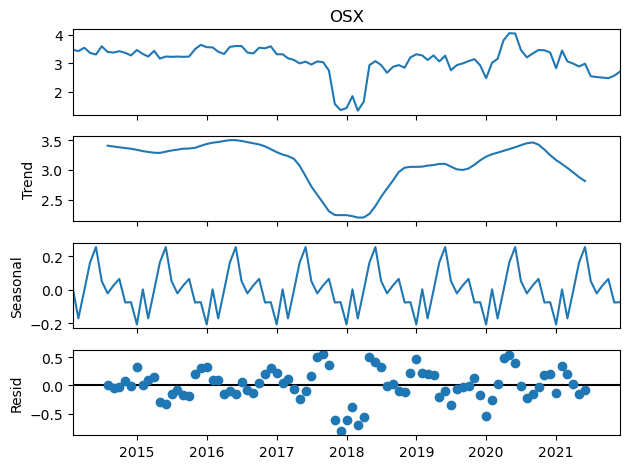

In [15]:
from statsmodels.tsa.seasonal import seasonal_decompose

ts = df_os_share["Linux"] 

decomposition = seasonal_decompose(ts, model='additive', period=12)
decomposition.plot()
plt.show()

ts = df_os_share["Windows"] 

decomposition = seasonal_decompose(ts, model='additive', period=12)
decomposition.plot()
plt.show()

ts = df_os_share["OSX"] 

decomposition = seasonal_decompose(ts, model='additive', period=12)
decomposition.plot()
plt.show()



This plot from statsmodels is a very good indicator that the data is seasonal, which calls for an autoregression model that is suited to interpret seasonal data. 

After filtering for OS share data, then pivoting to get 1 column per OS, we can now prep for the model. I believe SARIMA, or Seasonal AutoRegressive Integrated Moving Average, will be the optimal model to use in this context because of its ability to work with seasonal time-series data.

In [16]:
df_os_share

index,Linux,OSX,Windows
date,,,
2014-02-01,0.86,3.47,94.93
2014-03-01,1.30,3.42,95.17
2014-04-01,1.20,3.54,95.12
2014-05-01,1.26,3.36,95.25
2014-06-01,1.10,3.30,95.50
...,...,...,...
2021-08-01,1.00,2.51,96.49
2021-09-01,1.02,2.49,96.49
2021-10-01,1.05,2.47,96.47


In [ ]:
df_os_share = df_os_share.asfreq('MS')
linux_ts = df_os_share['Linux']['2014-01-01':'2021-12-31'].dropna()
print(f"Data prepared for the range: {linux_ts.index.min().date()} to {linux_ts.index.max().date()}.")


train_data = linux_ts[:'2020-12-31']
test_data = linux_ts['2021-01-01':]
print(f"Training data points : {len(train_data)}, Testing data points {len(test_data)}.") #split

n_periods = len(test_data)
forecast, conf_int = sarima_model.predict(n_periods=n_periods, return_conf_int=True)

forecast_series = pd.Series(forecast, index=test_data.index) 



Data prepared for the range: 2014-02-01 to 2021-12-01.
Training data points : 83, Testing data points 12.


/Users/jomus/miniforge3/envs/sarima_env/lib/python3.11/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/jomus/miniforge3/envs/sarima_env/lib/python3.11/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [36]:
sarima_model = pm.auto_arima(train_data,
                           seasonal=True,
                           m=12)

sarima_model.summary()

/Users/jomus/miniforge3/envs/sarima_env/lib/python3.11/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/jomus/miniforge3/envs/sarima_env/lib/python3.11/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/jomus/miniforge3/envs/sarima_env/lib/python3.11/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/jomus/miniforge3/envs/sarima_env/lib/python3.11/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/jomus/miniforge3/envs/sarima_env/lib/python3.11/site-packages/sklearn/utils/deprecation.py:132: F

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   83
Model:               SARIMAX(1, 1, 1)   Log Likelihood                  83.500
Date:                Mon, 30 Jun 2025   AIC                           -160.999
Time:                        13:31:09   BIC                           -153.779
Sample:                    02-01-2014   HQIC                          -158.101
                         - 12-01-2020                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9071      0.081    -11.208      0.000      -1.066      -0.748
ma.L1          0.7145      0.158      4.532      0.000       0.405       1.024
sigma2         0.0076      0.001      9.827      0.000       0.006       0.009
===================================================================================
Ljung-Box (L1) (Q):                   0.25   Jarque-Bera (JB):               139.94
Prob(Q):                              0.62   Prob(JB):                         0.00
Heteroskedasticity (H):               0.51   Skew:                             1.45
Prob(H) (two-sided):                  0.08   Kurtosis:                         8.71
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

The protype is designed to automatically detect and utilize seasonality, but in our case discards seasonality as the threshold was not met / detected. In the model row, it has one set of parentheses, two would indicate that it has detected seasonality. This makes the model ARIMA definitionally. 

--- Evaluation on Test Set (2021) ---
Root Mean Squared Error (RMSE): 0.1294


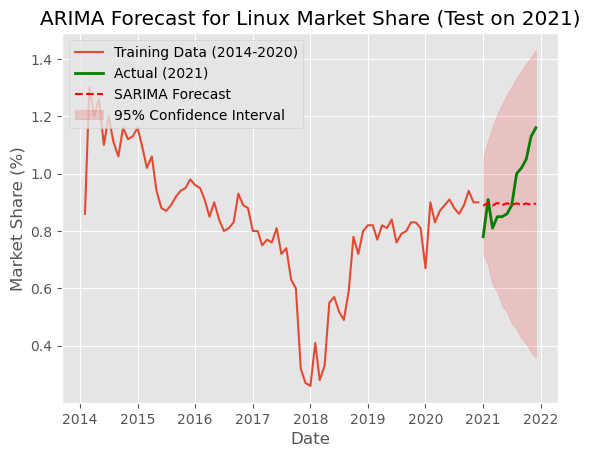

In [ ]:
# RMSE to evaluate 
mse = mean_squared_error(test_data, forecast_series)
rmse = np.sqrt(mse) # RMSE is the square root of MSE

print(f"--- Evaluation on Test Set (2021) ---")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")


plt.style.use('ggplot')
plt.plot(train_data, label='Training Data (2014-2020)')
plt.plot(test_data, label='Actual (2021)', color='green', linewidth=2)
plt.plot(forecast_series, label='SARIMA Forecast', color='red', linestyle='--')
plt.fill_between(forecast_series.index,
                 conf_int[:, 0],
                 conf_int[:, 1], color='red', alpha=.15, label='95% Confidence Interval')

plt.title('ARIMA Forecast for Linux Market Share (Test on 2021)')
plt.xlabel('Date')
plt.ylabel('Market Share (%)')
plt.legend(loc='upper left')
plt.grid(True)
plt.show()


NOT HAPPY with this models performance, very weak and underfit. The RMSE is more than 10% of the value range, which is big for this kind of market share data. RMSE was chosen to be very sensitive to deviations from the trend. 

Prophet is a forecasting model that may prove more applicable